# Bookhistorical research using the STCN

In [1]:

from SPARQLWrapper import SPARQLWrapper, JSON
from IPython.core.display import display, HTML
import pandas as pd
import re
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context


In [2]:
endpoint = 'http://data.bibliotheken.nl/sparql'
sparql = SPARQLWrapper(endpoint)

def run_query(sparql_query):
    sparql.setQuery(sparql_query)
    sparql.setReturnFormat(JSON)
    data = sparql.query().convert()
    df = pd.json_normalize(data['results']['bindings'])  
    return df
    
def show_results(df):
    for i,row in df.iterrows():
        for column in df.columns:
            if re.search('value$' , column):
                print( f'{column} => {row[column]}' )
        print('-------')
    return df

## Find all available data about an individual work

The book entitled "De medicyn-winckel, of ervaren huys-houder: zijnde het III. deel van het vermakelyck landt-leven" written by Petrus Nylandt and printed by Marcus Willemsz Doornick has ID "http://data.bibliotheken.nl/id/nbt/p192741446". We can retrieve data about this specific title using the following query. 

In [3]:
query = """

PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX schema: <http://schema.org/>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT ?o ?p WHERE {


  
<http://data.bibliotheken.nl/id/nbt/p192741446> ?o ?p .

}

"""
df = run_query(query)

In [4]:
print('The result of this query shows information about the following aspects:\n')
for i, row in df.iterrows():
    print(f"{row['o.value']}: {row['p.value']}\n")

The result of this query shows information about the following aspects:

http://www.w3.org/1999/02/22-rdf-syntax-ns#type: http://schema.org/CreativeWork

http://www.w3.org/1999/02/22-rdf-syntax-ns#type: http://schema.org/Book

http://www.w3.org/1999/02/22-rdf-syntax-ns#type: http://schema.org/ProductModel

http://schema.org/author: nodeID://b266094235

http://schema.org/alternateName: Het vermakelijck landt-leven. Part 3

http://schema.org/description: Includes: Den naerstigen byen-houder, onderrechtende hoe men [...] de byen [...] onderhouden sal; and: De verstandige kock, of Sorghvuldige huyshoudster

http://schema.org/about: http://data.bibliotheken.nl/id/thes/p155446258

http://schema.org/about: http://data.bibliotheken.nl/id/thes/p155446223

http://schema.org/inLanguage: nl

http://schema.org/name: De medicyn-winckel, of ervaren huys-houder: zijnde het III. deel van het vermakelyck landt-leven.

http://schema.org/publication: nodeID://b266603530

http://data.bibliotheken.nl/def#st

How can we find the IDs of books that have been decsribed in the SCTN? The queries below help us to find the necessary information. 

To get a sense of the number of titles we are dealing with, we work with a query which counts all of the titles which are part of the STCN dataset. 

In [5]:
query = """

PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX schema: <http://schema.org/>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT COUNT(?title) WHERE { 
?title schema:mainEntityOfPage ?mainEntity .
?mainEntity schema:isPartOf <http://data.bibliotheken.nl/id/dataset/stcn>  . 

}

"""

df = run_query(query)
print( f'The STCN dataset contains {df.iloc[0]["callret-0.value"]} records')



The STCN dataset contains 216051 records


Printing the full list of records would obviously demand an enormous amount of space. The query below only lists the first 15 titles. 

In [6]:
query = """

PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX schema: <http://schema.org/>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT ?title WHERE { 
?title schema:mainEntityOfPage ?mainEntity .
?mainEntity schema:isPartOf <http://data.bibliotheken.nl/id/dataset/stcn>  . 
}
LIMIT 15

"""

df = run_query(query)

In [7]:
for title in df['title.value']:
    print(title)

http://data.bibliotheken.nl/id/nbt/p82210427X
http://data.bibliotheken.nl/id/nbt/p822194570
http://data.bibliotheken.nl/id/nbt/p822196093
http://data.bibliotheken.nl/id/nbt/p82219628X
http://data.bibliotheken.nl/id/nbt/p822205521
http://data.bibliotheken.nl/id/nbt/p822205688
http://data.bibliotheken.nl/id/nbt/p82220682X
http://data.bibliotheken.nl/id/nbt/p822213907
http://data.bibliotheken.nl/id/nbt/p822217511
http://data.bibliotheken.nl/id/nbt/p822217937
http://data.bibliotheken.nl/id/nbt/p822218151
http://data.bibliotheken.nl/id/nbt/p822220679
http://data.bibliotheken.nl/id/nbt/p822227541
http://data.bibliotheken.nl/id/nbt/p822495724
http://data.bibliotheken.nl/id/nbt/p822496054


We can also zoom in on titles produced by a specific printer. 

The query below requests information about the books printed by Bonaventura Elzevier, whose ID is
http://data.bibliotheken.nl/doc/thes/p075545349

More specifically, the query requests the title, author, format, year of publication and the subject headings. 

In [8]:
query = """

PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX schema: <http://schema.org/>
PREFIX kb: <http://data.bibliotheken.nl/def#>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT ?resource ?title ?author_name ?format ?publ_year ?language ?subject_label ?collection WHERE {
  
?resource schema:publication ?publ .
?publ schema:publishedBy <http://data.bibliotheken.nl/id/thes/p075545349> .
?resource kb:bibliographicFormat ?format .
OPTIONAL {
?resource schema:name ?title . }
OPTIONAL {
?resource schema:author ?author . 
?author schema:name ?author_name . }
OPTIONAL {
?publ schema:startDate ?publ_year . }
OPTIONAL {
?publ schema:startDate ?publ_year . }
OPTIONAL { 
?resource schema:about ?subject .
?subject skos:prefLabel ?subject_label .
} 
OPTIONAL { 
?resource schema:inLanguage ?language .
} 
OPTIONAL {
?resource schema:mainEntityOfPage ?part_of . 
?part_of schema:isPartOf <http://data.bibliotheken.nl/id/dataset/stcn> .
}


}
"""
df = run_query(query)
ids = list(df["resource.value"].unique())

print( f'The STCN contain {len(ids)} titles printed by Bonaventura Elzevier.')


The STCN contain 1091 titles printed by Bonaventura Elzevier.


In [9]:
df_unique = df.drop_duplicates(subset='resource.value', keep="last")

nr = 10
print(f'These are the first {nr} titles:\n')

for i,row in df_unique.head(nr).iterrows():
    print( row['title.value'])
    if not( pd.isna(row['author_name.value'])):
        print(row['author_name.value'])
    print( row['publ_year.value'])
    print( row['resource.value'] , end='\n\n')

These are the first 10 titles:

Catalogvs bibliothecæ pvblicæ Lugduno-Batavæ
1636
http://data.bibliotheken.nl/id/nbt/p108214648

Catalogus librorvm qvi in bibliopolio Elseviriano venales exstant
1634
http://data.bibliotheken.nl/id/nbt/p108214974

Dispvtatio juridica de evictionibvs.
Melchior de Jonge
1630
http://data.bibliotheken.nl/id/nbt/p110602390

Oratio de differentia inter consolationes ethnicas ac christianas amicis plaga mortifera afflictis inculcandas.
Johannes Polyander
1636
http://data.bibliotheken.nl/id/nbt/p111024196

Oratio inauguralis de officio theologi.
Fridericus Spanhemius
1643
http://data.bibliotheken.nl/id/nbt/p111781531

Dispvtationvm jvridicarvm prima, de statutis, seu institutis civitatum.
Jacobus Maestertius
1640
http://data.bibliotheken.nl/id/nbt/p111966043

Dispvtationvm jvridicarvm secvnda, de vi ac potestate legis.
Jacobus Maestertius
1640
http://data.bibliotheken.nl/id/nbt/p111966345

Dispvtationvm jvridicarvm tertia, de potestate principis.
Jacobus Maeste

## Annual productivity

In [10]:
from collections import Counter

productivity = df_unique[pd.to_numeric(df_unique['publ_year.value'], errors = 'coerce').notnull()]
productivity = productivity.sort_values( 'publ_year.value' )
productivity['publ_year.value'] = productivity['publ_year.value'].astype(int)


earliest = productivity['publ_year.value'].min()
latest = productivity['publ_year.value'].max()

nr_books = Counter(productivity['publ_year.value'])


x_axis = []
y_axis = []

for year in range(int(earliest),int(latest)+1):
    x_axis.append(year)
    y_axis.append( nr_books[ year ] )

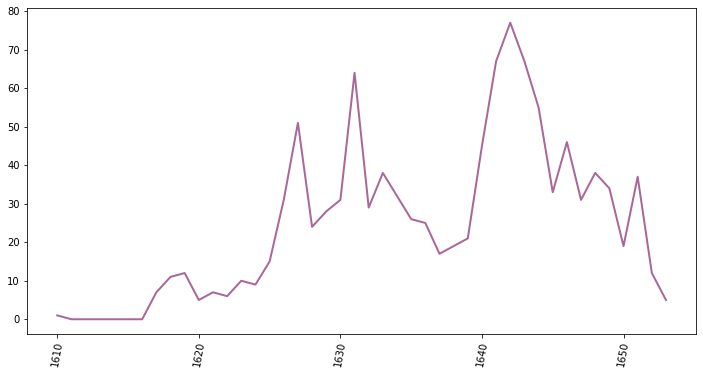

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure( figsize = ( 12, 6))
ax = sns.lineplot( x= x_axis , y= y_axis , 
                  color= '#AA6799', linestyle='solid',linewidth=2 )
plt.xticks(rotation= 80)
plt.show()

## Formats

In [12]:
nr_books = df_unique.groupby('format.value')['resource.value'].count()

In [13]:
print('The books were printed in the following formats:')
for book_format,count in nr_books.iteritems():
    word = 'book'
    if count>1:
        word += 's'
    print( f'{book_format} ({count} {word})')


The books were printed in the following formats:
12° (201 books)
16° (7 books)
18° (2 books)
1° (1 book)
24° (99 books)
2° (58 books)
4° (576 books)
4° oblong (2 books)
8° (144 books)
8° oblong (1 book)


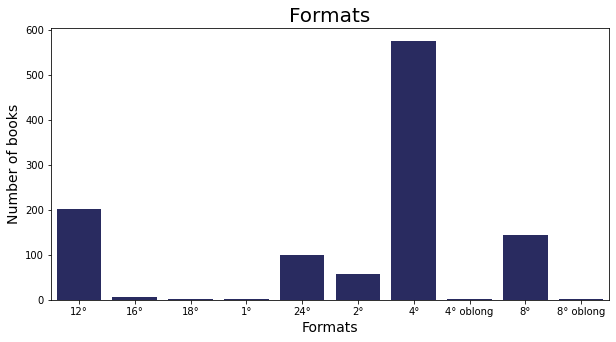

In [14]:
nr_books = nr_books.sort_index()

fig = plt.figure( figsize=( 10 , 5 ) )


graph = sns.barplot( x= nr_books.index, y= nr_books.values,  dodge=False , color = '#202369' )

graph.set_title('Formats' , size = 20) 
graph.set_xlabel('Formats' , size = 14) 
graph.set_ylabel('Number of books' , size = 14 )

plt.show()

## Subjects

In [15]:
subjects = Counter(df['subject_label.value'])
subjects = subjects.most_common()
x_axis = []
y_axis = []
for s,count in subjects:
    y_axis.append(s)
    x_axis.append(count)

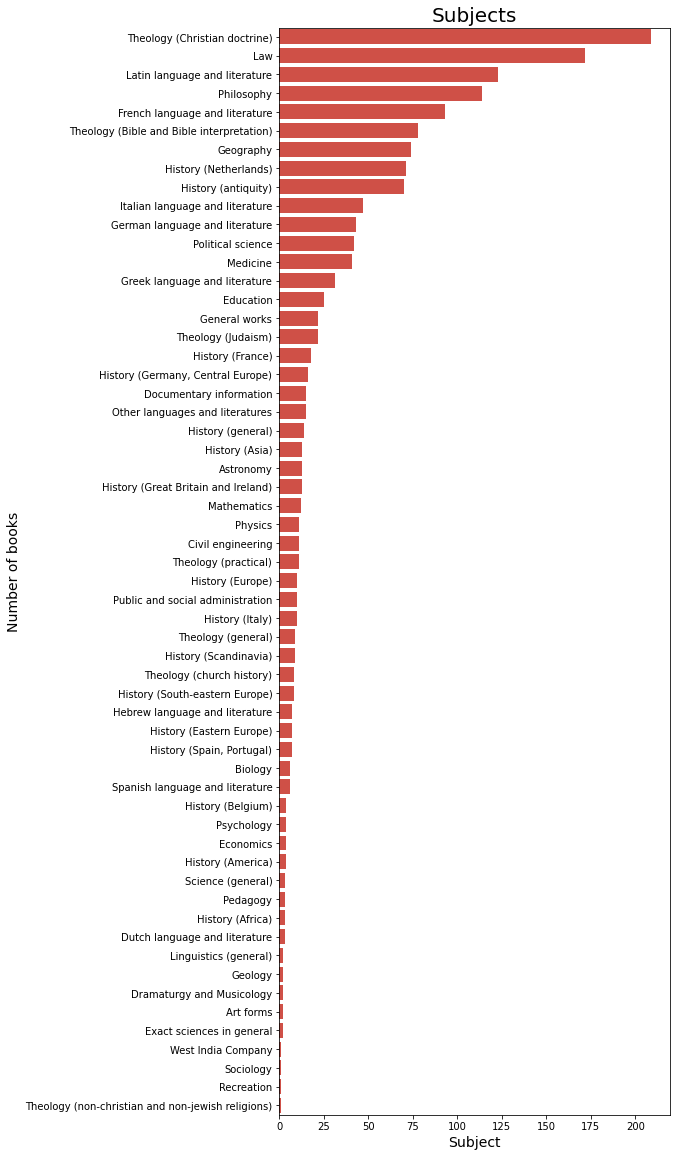

In [16]:
nr_books = nr_books.sort_index()

fig = plt.figure( figsize=( 7 , 20 ) )


graph = sns.barplot( x= x_axis, y= y_axis,  dodge=False , color = '#e63c30' )

graph.set_title('Subjects' , size = 20) 
graph.set_xlabel('Subject' , size = 14) 
graph.set_ylabel('Number of books' , size = 14 )

plt.show()

## Languages


In [17]:
languages = Counter(df['language.value'])
languages = languages.most_common()
x_axis = []
y_axis = []
for s,count in languages:
    y_axis.append(s)
    x_axis.append(count)

In [18]:
y_axis

['la', 'fr', 'grc', 'it', 'de', 'nl', 'mul', 'he', 'ar', 'syr', 'peo', 'es']

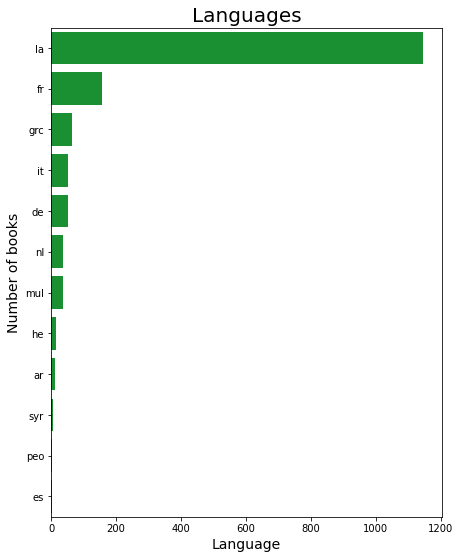

In [19]:
nr_books = nr_books.sort_index()

fig = plt.figure( figsize=( 7 , 0.75*len(y_axis) ) )


graph = sns.barplot( x= x_axis, y= y_axis,  dodge=False , color = '#08a327' )

graph.set_title('Languages' , size = 20) 
graph.set_xlabel('Language' , size = 14) 
graph.set_ylabel('Number of books' , size = 14 )

plt.show()

## Authors

In [20]:
df_authors = df.drop_duplicates(subset= ['resource.value','author_name.value'], keep="last")
freq = Counter()
nodes = []
edges = []
for i,row in df_authors.iterrows():
    if not(pd.isna(row['author_name.value'])):
        title = row['title.value']
        #title = row['title.value']
        nodes.append( ( title , 'Book' ) )
        nodes.append( ( row['author_name.value'] , 'Author' ) )
        edges.append( ( title , row['author_name.value']) )
        freq.update( [ row['author_name.value'] ] )

nodes = set(nodes)
edges = set(edges)

In [21]:
from pyvis.network import Network
net = Network(notebook=True , height="750px", width="100%" , bgcolor="#dce5f2" )

net.force_atlas_2based(
        gravity=-60,
        central_gravity=0.01,
        spring_length=100,
        spring_strength=0.08,
        damping=0.4,
        overlap= 0 )
             
for node,label in nodes:
    node_size = 15
    if label == 'Book':
        c ='#EE7733'
    else:
        c = '#007788'
        node_size = 15 + freq[node]     
    net.add_node( node , title=node , color= c , size = node_size )
                

for source,target in edges:
    net.add_edge( source , target )
                              


net.show( f'network1.html')

## Other printers in the STCN

The analyses that were performed for Bonaventura Elzevier can be applied to all the printers who are described in the STCN. The IDs of these printers can be found using the query below.

In [23]:
#http://data.bibliotheken.nl/id/thes/p075545349
query = """

PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX schema: <http://schema.org/>
PREFIX kb: <http://data.bibliotheken.nl/def#>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT DISTINCT ?publisher ?publisher_name WHERE {
  
?book schema:mainEntityOfPage ?part_of . 
?part_of schema:isPartOf <http://data.bibliotheken.nl/id/dataset/stcn> .


?book schema:publication ?publ .
?publ schema:publishedBy ?publisher .
OPTIONAL {
?publisher schema:name ?publisher_name .
}

}
ORDER BY ?publisher_name
"""


df = run_query(query)   
printers = df.drop_duplicates(subset='publisher.value', keep="last")

print( f'The STCN describes books produced by {printers.shape[0]} printers.' )

nr = 20
print(f'The list below contains the names and IDs of the first {nr} printers that were found.\n')

for i,p in printers.head(15).iterrows():
    print( f"{ p['publisher_name.value'] } ({p['publisher.value']}) " )

The STCN describes books produced by 11031 printers.
The list below contains the names and IDs of the first 20 printers that were found.

's Compagnies Druckers (http://data.bibliotheken.nl/id/thes/p134960815) 
's Compagnies Drukkerij (http://data.bibliotheken.nl/id/thes/p134962230) 
'sLands Drukkerij (http://data.bibliotheken.nl/id/thes/p136458378) 
A.L.P. (http://data.bibliotheken.nl/id/thes/p075537656) 
A.M. (http://data.bibliotheken.nl/id/thes/p112638147) 
Aa, Boudewijn Janssoon van der (II) (http://data.bibliotheken.nl/id/thes/p127736859) 
Aa, Boudewijn van der (I) (http://data.bibliotheken.nl/id/thes/p075537214) 
Aa, Cornelis van der (http://data.bibliotheken.nl/id/thes/p127845216) 
Aa, Cornelis van der (http://data.bibliotheken.nl/id/thes/p14333753X) 
Aa, Hillebrand van der (http://data.bibliotheken.nl/id/thes/p075537222) 
Aa, Pierre van der (http://data.bibliotheken.nl/id/thes/p180033603) 
Aa, Pieter Janssoon van der (II) (http://data.bibliotheken.nl/id/thes/p127845607) 
Aa, Pi

## Prayer Books

In [24]:
query = """

PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX schema: <http://schema.org/>
PREFIX kb: <http://data.bibliotheken.nl/def#>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT ?book ?title ?publ_year WHERE {  
?book schema:genre <http://data.bibliotheken.nl/id/thes/p155444875> .
?book schema:name ?title . 

OPTIONAL {
?book schema:publication ?publ .
?publ schema:startDate ?publ_year . }

}
"""
book_of_hours = run_query(query)

In [25]:
from collections import Counter

df_unique = book_of_hours.drop_duplicates(subset='book.value', keep="last")
print(f'There are {df_unique.shape[-0]} books of hours in the KB.')

#df_unique = df_unique[ df_unique['publ_year.value'].astype(int,errors = 'ignore') >= 1500 ]
#df_unique = df_unique[ df_unique['publ_year.value'].astype(int,errors = 'ignore') < 1600 ]


df_unique = df_unique[pd.to_numeric(df_unique['publ_year.value'], errors='coerce').notnull()]

freq = Counter(df_unique['publ_year.value'])

x_axis = list(freq.keys())
y_axis = list(freq.values())


There are 2110 books of hours in the KB.


In [26]:
for i,row in df_unique.iterrows():
    print( f"{row['book.value']}\n{row['title.value']} ({row['publ_year.value']})" )


http://data.bibliotheken.nl/id/nbt/p107193175
Het vernieuwde paradys-hofken, vol allerhande leer-rijcke- [...] vreughde-gebeden. (1700)
http://data.bibliotheken.nl/id/nbt/p107232138
Hemels palm-hof, ofte Groot getyde-boek. (1698)
http://data.bibliotheken.nl/id/nbt/p107702126
Breviores quaeque elegantioresque epistolae. (1518)
http://data.bibliotheken.nl/id/nbt/p108055051
Breviarium Rigense (1513)
http://data.bibliotheken.nl/id/nbt/p108092011
[Getijdenboek] (1500)
http://data.bibliotheken.nl/id/nbt/p108092453
Die ghetijden van onser lieuer vrouwē met vele schoon louen ende oracien (1505)
http://data.bibliotheken.nl/id/nbt/p108093689
Die ghetijden van onser lieuer vrouwē met vele schoone louen ende oracien (1512)
http://data.bibliotheken.nl/id/nbt/p108093778
Ghetijden van onser liever Vrouwen (1516)
http://data.bibliotheken.nl/id/nbt/p108094855
Die ghetijden van onser lieuer Vrouwē, ende vanden helylighē[!] cruce, en̄ vandē heylighē gheest met die seuen psalmen (1533)
http://data.b

For more information, see
* https://ecritures.medium.com/data-bibliotheken-nl-bevragen-via-de-wikidata-query-service-wdqs-e593a6a36d8c
* https://ecritures.medium.com/topstukken-in-de-koninklijke-bibliotheek-b32780f314f8